В этом семинаре мы будем работать с материалами соревнования [Kaggle Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection). Данные немного изменены по сравнению с исходными. Вам нужны файлы, которые находятся по следующим ссылкам:

* train_transaction.csv: https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0
* train_identity.csv: https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0
* test_transaction.csv: https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0
* test_identity.csv: https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0
* sample_submission.csv:
https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0



In [ ]:
# скачиваем файлы
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

--2020-11-02 09:42:05--  https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5iuef7c9ljj84t6/train_transaction.csv [following]
--2020-11-02 09:42:06--  https://www.dropbox.com/s/raw/5iuef7c9ljj84t6/train_transaction.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf566670060188b00308e32eb6.dl.dropboxusercontent.com/cd/0/inline/BCYODMbkRV3vDe0WpACW6AUx7cLsii2eNNDycdXHk4GpztSLG9ApVckhi6ZiCfQjiDyL5fpOwxmUw97vbRYA8aYc_dEyW5yU-TWAu1aiPHZ_xeMH_euEiEv6cVZfT2di_yg/file# [following]
--2020-11-02 09:42:06--  https://ucdf566670060188b00308e32eb6.dl.dropboxusercontent.com/cd/0/inline/BCYODMbkRV3vDe0WpACW6AUx7cLsii2eNNDycdXHk4GpztSLG9ApVckhi6ZiCfQjiDyL5fpOwxmUw97

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm, tqdm_notebook

sns.set()

%matplotlib inline

In [ ]:
INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))

In [ ]:
train_transaction.shape, train_identity.shape, test_transaction.shape, test_identity.shape

((417559, 394), (110666, 41), (172981, 393), (33567, 41))

Отнюдь не для всех транзакций есть информация из `identity`.

In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_transaction.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
417554,3404554,0,10540759,335.000,W,2538,476.0,150.0,visa,166.0,debit,126.0,87.0,NaN,NaN,gmail.com,NaN,1.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,184.0,184.0,144.0,184.0,144.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417555,3404555,0,10540766,160.500,W,6019,583.0,150.0,visa,226.0,credit,269.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,128.0,128.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417556,3404556,0,10540775,230.079,C,5059,138.0,200.0,visa,226.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,10.0,0.0,2.0,0.0,2.0,2.0,5.0,0.0,6.0,3.0,3.0,5.0,2.0,47.0,47.0,0.0,47.0,0.0,47.0,0.0,1.958333,0.958333,...,0.0,0.0,2.0,3.0,2.0,1.0,460.158813,622.56781,541.121582,0.0,162.408997,0.0,80.962799,0.0,0.0,0.0,460.158813,460.158813,460.158813,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417557,3404557,0,10540789,105.000,W,6697,111.0,150.0,visa,195.0,debit,299.0,87.0,NaN,NaN,gmail.com,NaN,6.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,14.0,4.0,37.0,37.0,1.0,261.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,2682.50000,542.000000,0.0,2682.500000,0.0,542.000000,445.0,2585.5,445.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417558,3404558,0,10540797,226.000,W,10112,360.0,150.0,visa,166.0,debit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,63.0,NaN,64.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_transaction.isnull().mean().sort_values(ascending=False).rename('% of NaNs')[:20]

D7       0.935468
dist2    0.929864
D13      0.893510
D14      0.891417
D12      0.885628
D6       0.872928
D8       0.864560
D9       0.864560
V142     0.843146
V158     0.843146
V153     0.843146
V154     0.843146
V155     0.843146
V156     0.843146
V157     0.843146
V163     0.843146
V159     0.843146
V160     0.843146
V161     0.843146
V162     0.843146
Name: % of NaNs, dtype: float64

# Компоновка данных

Итак, в данных есть признаки с большим числом пропусков.

Объединим `transaction` и `identity` в одну таблицу:

In [ ]:
df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
y_train = df_train['isFraud'].astype("uint8").copy()
df_train.shape

(417559, 434)

In [ ]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
del train_transaction, train_identity

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.4+ GB


Данные занимают больше 1.4 Гб в памяти, что может сильно сказаться на скорости обучения. Сожмем данные, изменив тип некоторых признаков. Оригинал функции: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65.

In [ ]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [ ]:
df_train, df_train_NAlist = reduce_mem_usage(df_train)

100%|██████████| 434/434 [00:51<00:00,  8.35it/s]


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(7), int8(9), object(31), uint16(40), uint32(3), uint8(264)
memory usage: 380.3+ MB


In [ ]:
df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
df_test.shape

(172981, 433)

In [ ]:
del test_transaction, test_identity

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 572.8+ MB


In [ ]:
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [00:25<00:00, 17.18it/s]


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(78), int16(6), int8(9), object(31), uint16(57), uint32(3), uint8(249)
memory usage: 159.0+ MB


# EDA

Данные сильно несбалансированы:

In [ ]:
y_train.value_counts()

0    402838
1     14721
Name: isFraud, dtype: int64

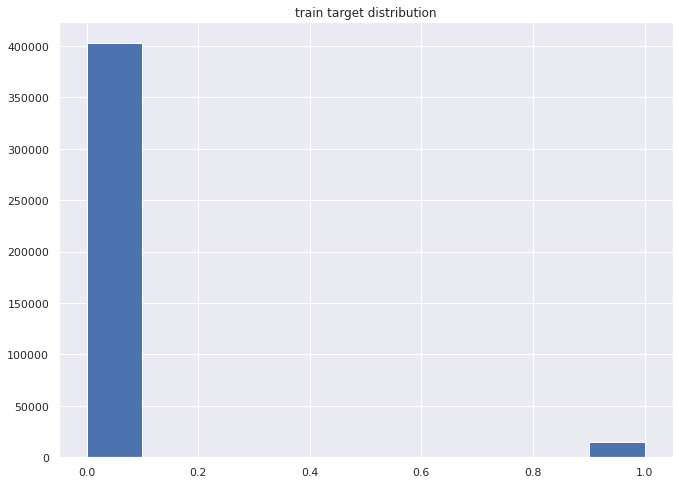

In [ ]:
plt.figure(figsize=(11, 8))
plt.title('train target distribution')
plt.hist(y_train)
plt.show()

Можно заметить, что данные содержат признак, отвечающий за момент времени совершения транзакции - `'TransactionDT'`. Изучим его подробнее.

In [ ]:
df_train['TransactionDT'].min(), df_test['TransactionDT'].max(), df_test['TransactionDT'].max() - df_train['TransactionDT'].min()

(86400, 15811131, 15724731)

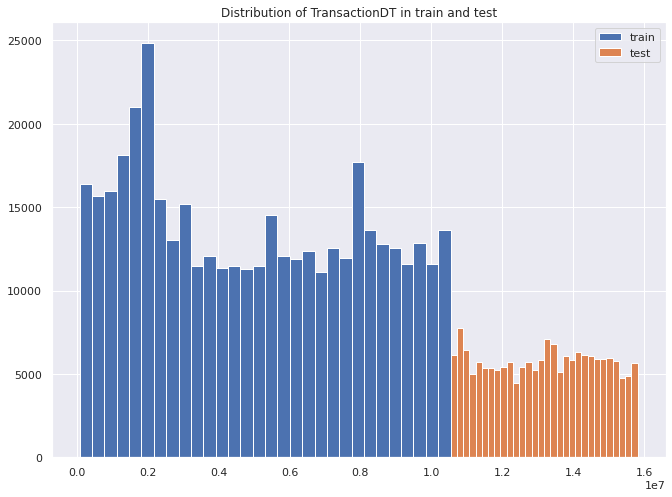

In [ ]:
plt.figure(figsize=(11, 8))
plt.title('Distribution of TransactionDT in train and test')
plt.hist(df_train['TransactionDT'], label='train', bins=30)
plt.hist(df_test['TransactionDT'], label='test', bins=30)
plt.legend(loc='best')
plt.show()

Можно предположить, что время для этого признака измеряется в секундах, тогда похоже на то, что данные из трейна и теста - это данные за полгода.

In [ ]:
(df_test['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24)

181.99920138888888

Также, если время измеряется в секундах, то, судя по всему, обучающая часть выборки включает в себя данные за 4 месяца, а тестовая - за следующие 2:

In [ ]:
(df_train['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24), (df_test['TransactionDT'].max() - df_test['TransactionDT'].min()) / (3600 * 24)

(120.99996527777778, 60.998900462962965)

Построим распределения различных признаков.

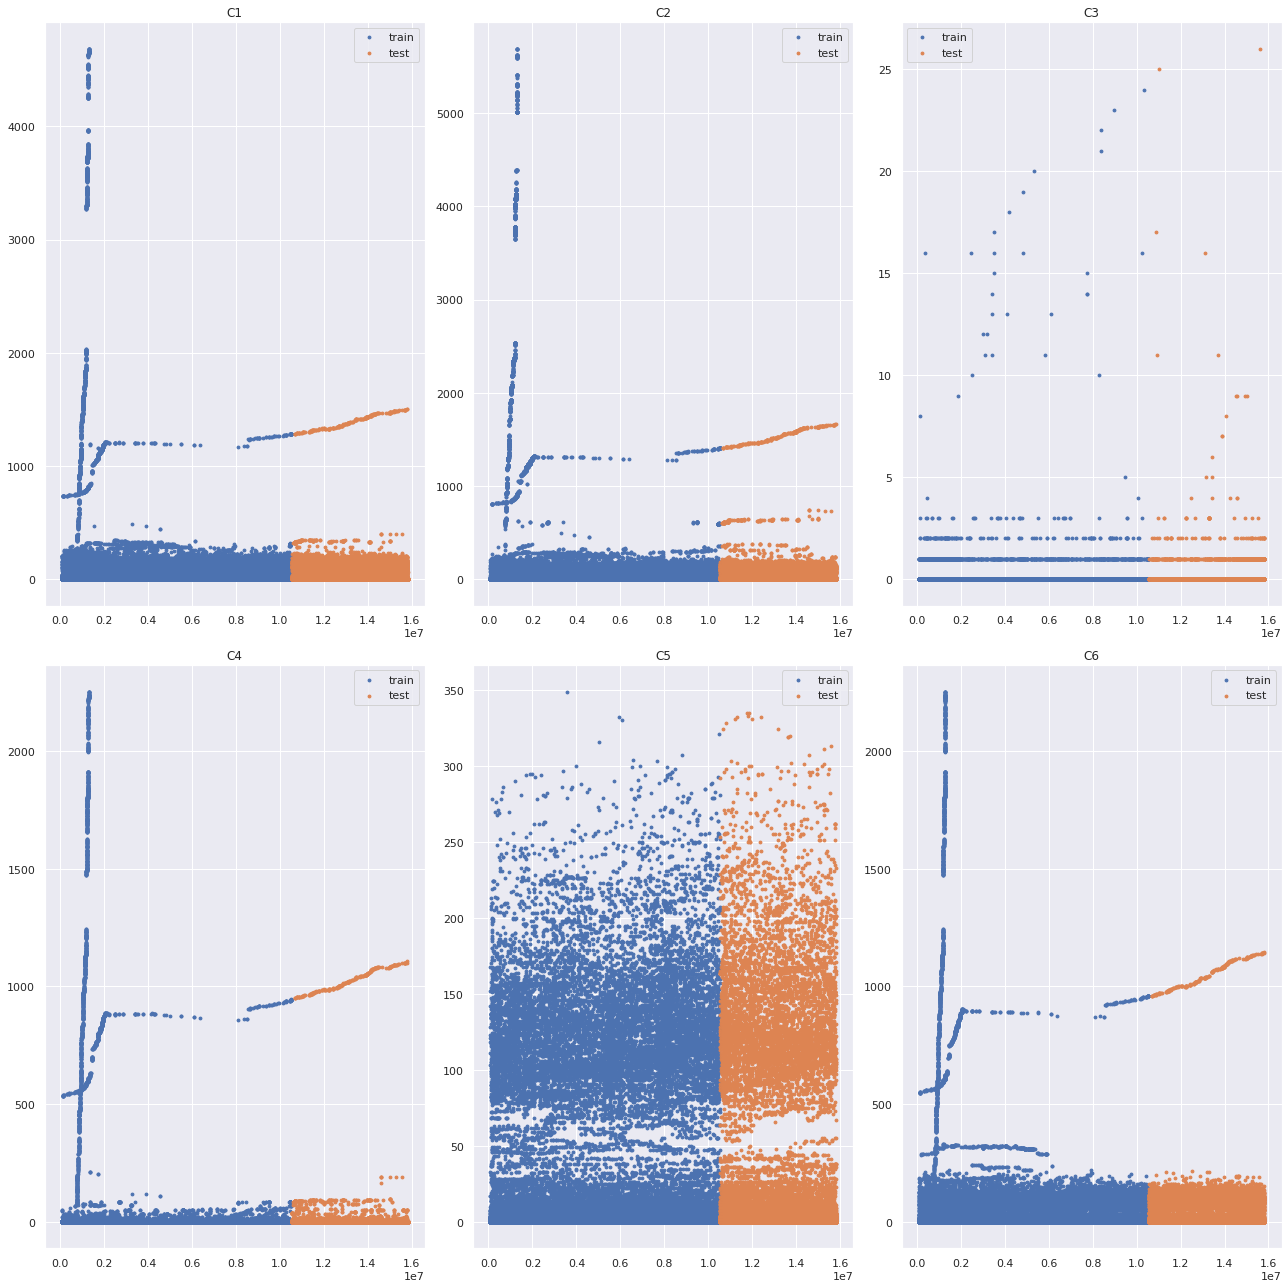

CPU times: user 24.2 s, sys: 1.23 s, total: 25.4 s
Wall time: 25.3 s


In [ ]:
%%time

c_features = [col for col in df_train.columns if col.startswith('C')]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 18))
for i in range(len(c_features))[:6]:
    col = c_features[i]
    j1 = i // 3
    j2 = i % 3
    ax = axes[j1, j2]
    ax.set_title(col)
    ax.scatter(df_train['TransactionDT'], df_train[col], s=8, label='train')
    ax.scatter(df_test['TransactionDT'], df_test[col], s=8, label='test')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

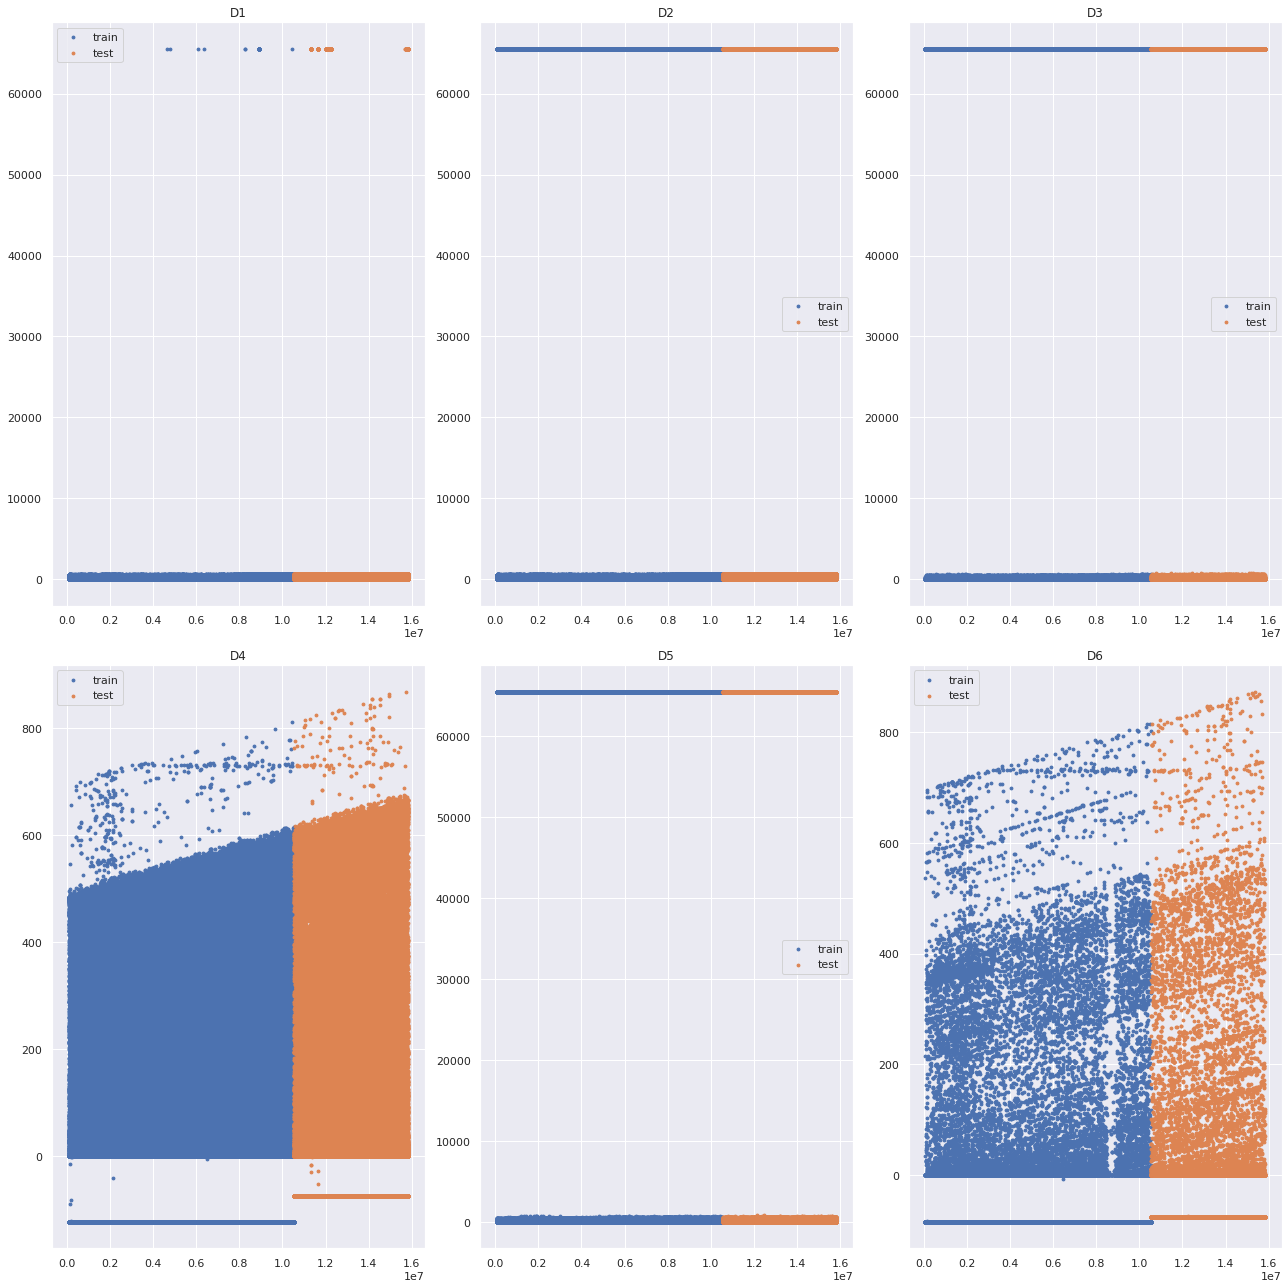

CPU times: user 47.5 s, sys: 1.22 s, total: 48.8 s
Wall time: 48.7 s


In [ ]:
%%time

d_features = [col for col in df_train.columns if col.startswith('D')][:-2]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 18))
for i in range(len(d_features))[:6]:
    col = d_features[i]
    j1 = i // 3
    j2 = i % 3
    ax = axes[j1, j2]
    ax.set_title(col)
    ax.scatter(df_train['TransactionDT'], df_train[col], s=8, label='train')
    ax.scatter(df_test['TransactionDT'], df_test[col], s=8, label='test')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

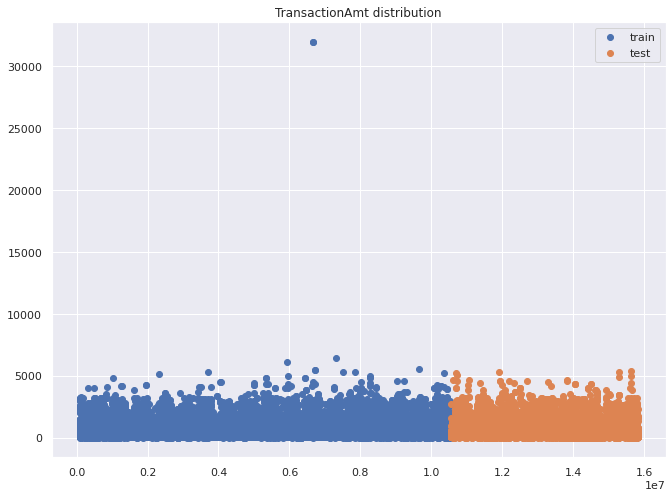

In [ ]:
plt.figure(figsize=(11, 8))
plt.title('TransactionAmt distribution')
plt.scatter(df_train['TransactionDT'], df_train['TransactionAmt'], label='train')
plt.scatter(df_test['TransactionDT'], df_test['TransactionAmt'], label='test')
plt.legend(loc='best')
plt.show()

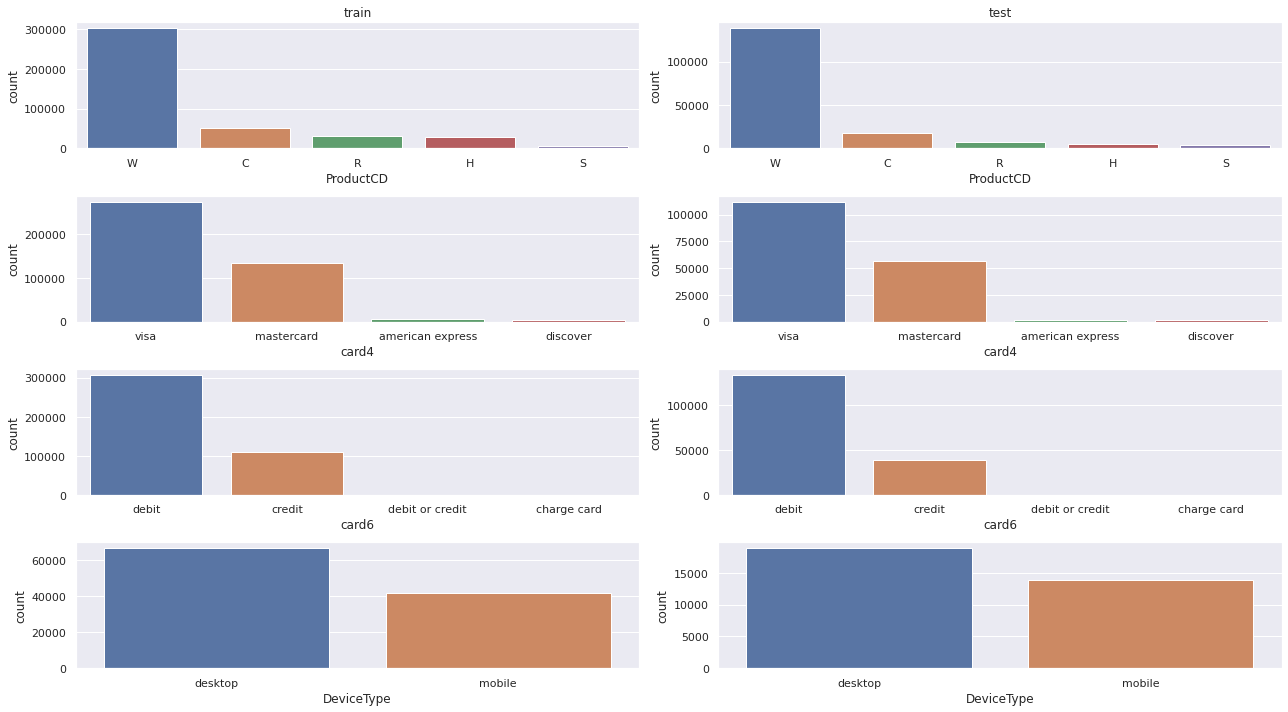

CPU times: user 2.33 s, sys: 101 ms, total: 2.43 s
Wall time: 2.32 s


In [ ]:
%%time

cat_fts = ['ProductCD', 'card4', 'card6', 'DeviceType']
fig, ax = plt.subplots(nrows=len(cat_fts), ncols=2, figsize=(18, 10))
ax[0, 0].set_title('train')
ax[0, 1].set_title('test')

for i in range(len(cat_fts)):
    col = cat_fts[i]
    sns.countplot(x=col, ax=ax[i, 0], data=df_train, order=df_train[col].value_counts().index)
    sns.countplot(x=col, ax=ax[i, 1], data=df_test, order=df_train[col].value_counts().index)
plt.tight_layout()
plt.show()

Посмотрим на то, как некоторые признаки связаны с целевой переменной. Это может помочь при генерации новых признаков.

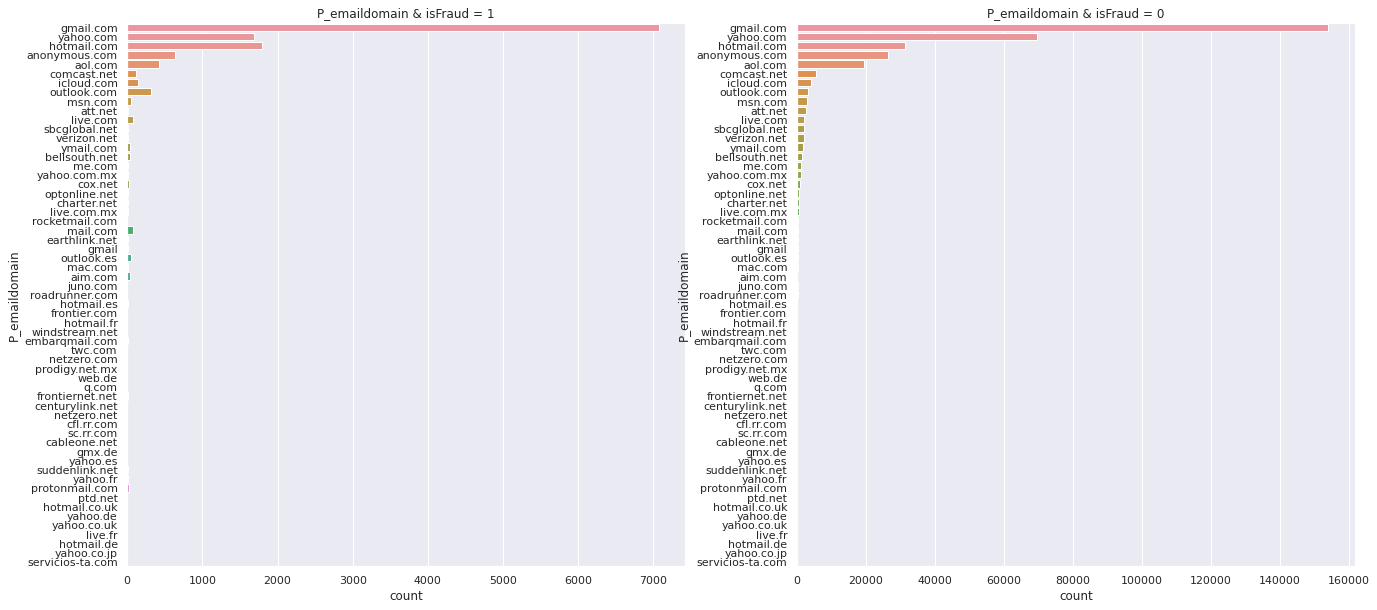

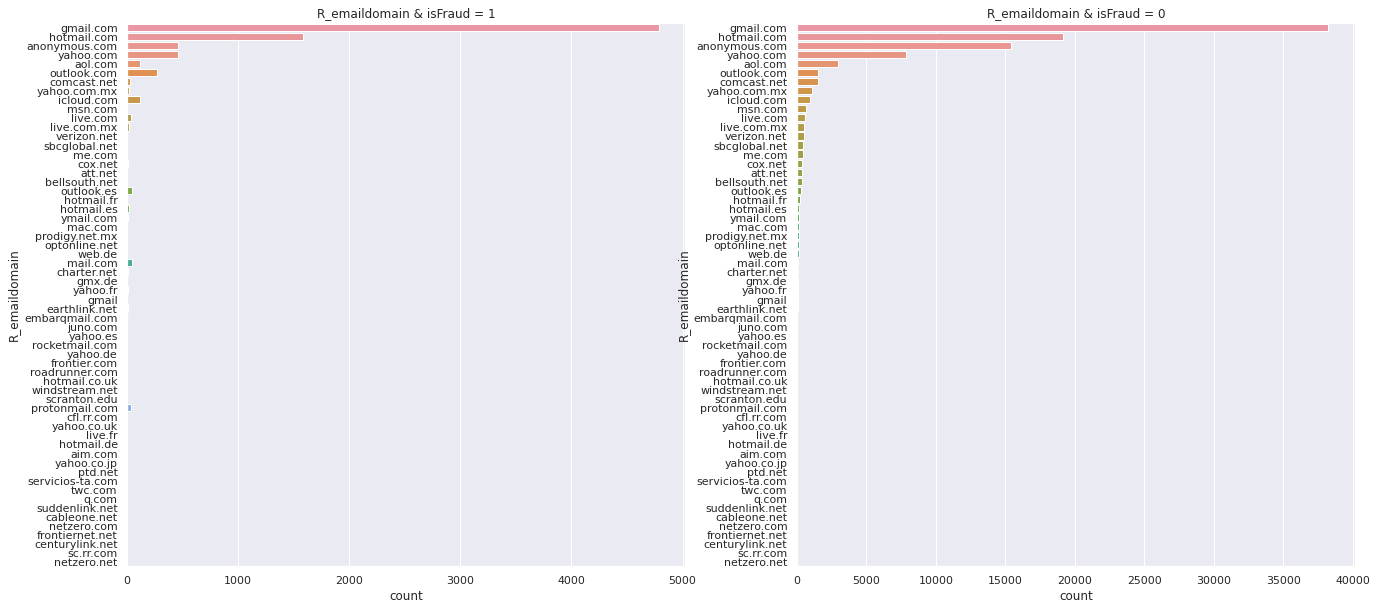

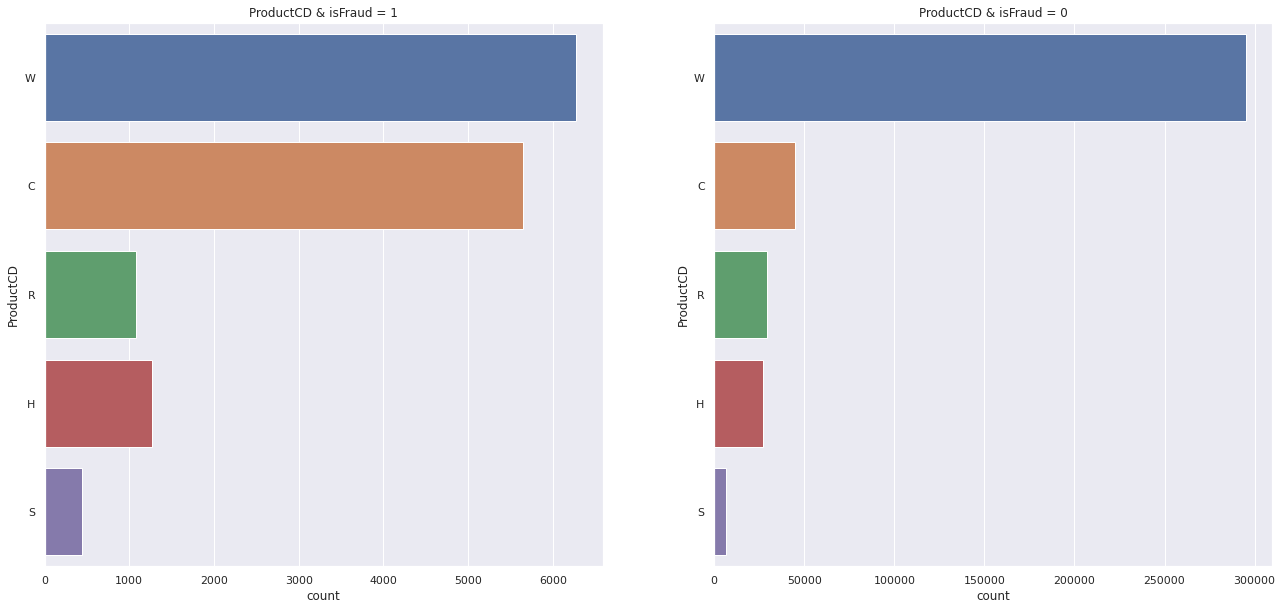

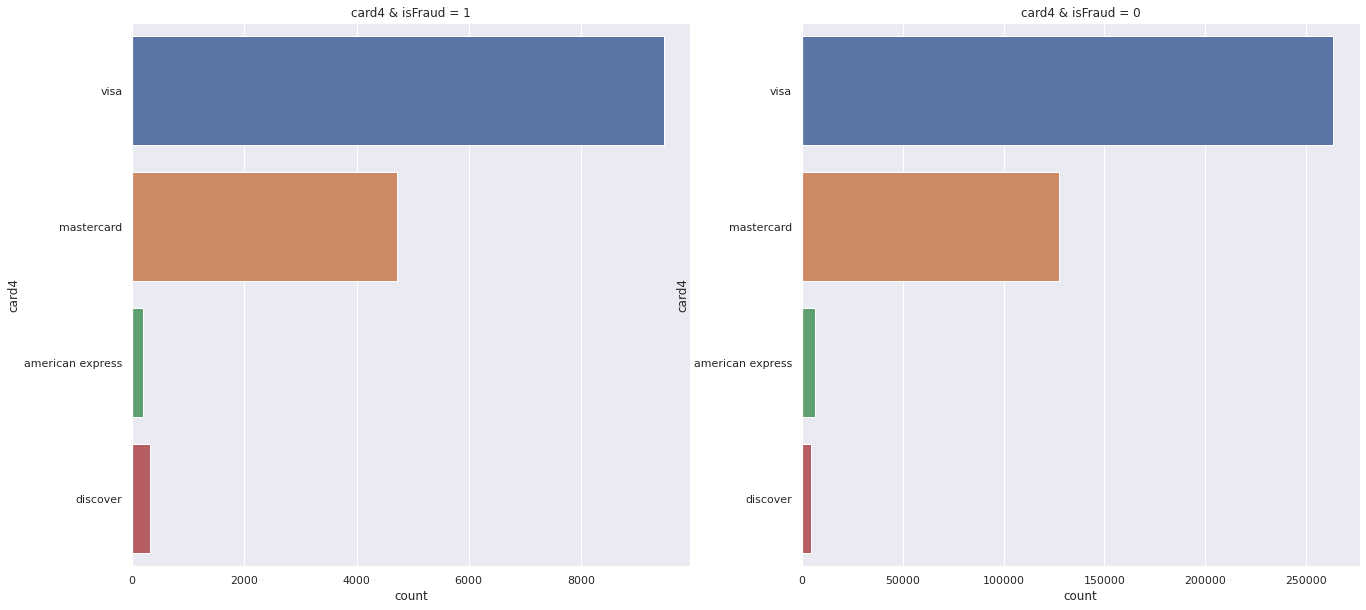

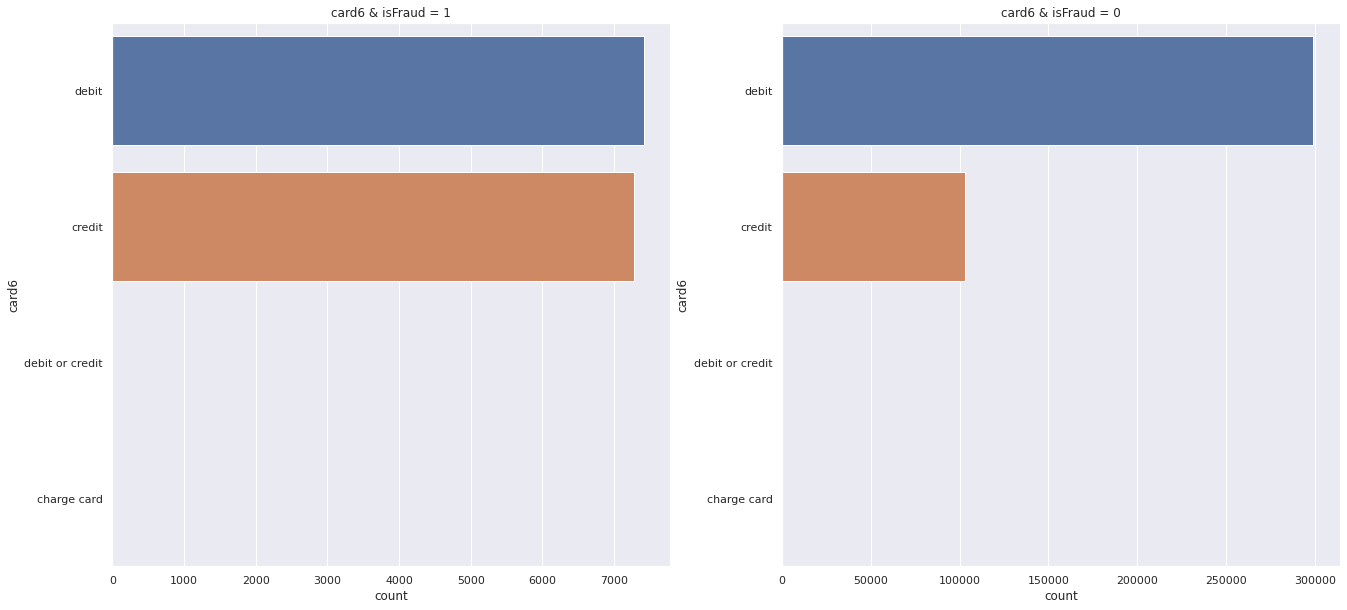

CPU times: user 9.03 s, sys: 259 ms, total: 9.29 s
Wall time: 9.29 s


In [ ]:
%%time

cols_target = ['P_emaildomain', 'R_emaildomain', 'ProductCD', 'card4', 'card6']

for col in cols_target:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    sns.countplot(y=col, ax=ax[0], data=df_train.loc[df_train['isFraud'] == 1], order=df_train[col].value_counts().index)
    ax[0].set_title(col + ' & isFraud = 1')
    sns.countplot(y=col, ax=ax[1], data=df_train.loc[df_train['isFraud'] == 0], order=df_train[col].value_counts().index)
    ax[1].set_title(col + ' & isFraud = 0')
    plt.show()

# Построение baseline

В данных есть пропуски:

In [ ]:
print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 4.47002%
Missing data in test: 4.33051%


Заполним пропуски в столбцах, где значения выражаются числами - `-1`, а где строками - `'unseen_category'`.

In [ ]:
for col in df_train.columns.drop('isFraud'):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 0.00000%
Missing data in test: 0.00000%


In [ ]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(7), int8(9), object(31), uint16(40), uint32(3), uint8(264)
memory usage: 400.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(78), int16(6), int8(9), object(31), uint16(57), uint32(3), uint8(249)
memory usage: 164.0+ MB


(None, None)

Закодируем категориальные признаки с помощью [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) и сконвертируем их в [`category`](https://pandas.pydata.org/pandas-docs/version/0.23.4/categorical.html).

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df_train.info(), df_test.info()

100%|██████████| 433/433 [00:12<00:00, 33.76it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(80), int16(7), int8(9), uint16(40), uint32(3), uint8(264)
memory usage: 314.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(78), int16(6), int8(9), uint16(57), uint32(3), uint8(249)
memory usage: 128.6 MB


(None, None)

Перед тем, как обучать какие-либо модели, нужно настроить валидацию - для того, чтобы оценивать обобщающую способность без использования тестовой выборки. Несмотря на то, что модель можно применить к тестовой части и получить результат на лидерборде, отнюдь не факт, что такому результату можно доверять. Дело в том, что он рассчитывается по публичной части тестовой выборки - однако итоговый результат будет рассчитываться по приватной части после окончания соревнования. Распределение данных в публичной и приватной частях может различаться, и если вы будете оценивать качество только по результату на публичной части, может получиться так, что ваше итоговое место в соревновании будет сильно ниже того, что вы имели по ходу.

Однако бывают случаи, когда можно занять топовые места в соревновании и без настройки валидации, доверяя лишь результату на публичной части тестовой выборки. Пример: [описание решения победителя соревнования по детекции диабетической ретинопатии](https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/108065).

Техники валидации могут быть очень разными - от разбиения на обучающую/валидационную часть до [разбиения на группы с перемешиванием](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit). Для кросс-валидации может быть полезно воспользоваться модулем [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) из библиотеки `scikit-learn`.

Настройка корректной валидации очень зависит от поставленной задачи. Очевидно, в идеале нужно выбрать такой способ, который сможет отразить то, насколько хорошо модель справится с приватной частью тестовой выборки.

В части с EDA было выдвинуто следующее предположение: согласно поведению признака `TransactionDT`, в обучающей части выборки содержатся данные за 4 месяца. Давайте настроим кросс-валидацию с 4 фолдами, где в каждом случае будем брать в качестве валидационной части тот или иной месяц.

In [ ]:
(df_train['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24)

120.99996527777778

In [ ]:
month_length = 3600 * 24 * 30
df_train['TransactionDT'].shape

(417559,)

In [ ]:
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
print('Validation set 0 length:', len(fold0_idx))
print('Validation set 1 length:', len(fold1_idx))
print('Validation set 2 length:', len(fold2_idx))
print('Validation set 3 length:', len(fold3_idx))

Validation set 0 length: 134339
Validation set 1 length: 89399
Validation set 2 length: 92189
Validation set 3 length: 101632


In [ ]:
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

In [ ]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,99,150,1,142,1,315,87,19,65535,48,49,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,65535,13,-123,65535,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
1,2987001,0,86401,29.0,4,2755,404,150,2,102,1,325,87,65535,65535,16,49,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
2,2987002,0,86469,59.0,4,4663,490,150,4,166,2,330,87,287,65535,35,49,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
3,2987003,0,86499,50.0,4,18132,567,150,2,117,2,476,87,65535,65535,54,49,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112,112,0,94,0,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
4,2987004,0,86506,50.0,1,4497,514,150,2,102,1,420,87,65535,65535,16,49,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,65535,65535,-123,65535,-84,65535,-1.0,-1.0,...,0,70787,-13,-29,-73,-101,-47,-101,-37,-101,100.0,1,9,-480,1,1,166,9,542,144,99,9,3,10,99,99,2,1,1,7,123,32,164,3,1,0,1,1,1,954


В данных есть признак-идентификатор объекта - `'TransactionID'`. Заметим, что его значения в обучающей и тестовых выборках не пересекаются:

In [ ]:
set(df_train['TransactionID']).intersection(set(df_test['TransactionID']))

set()

Также не пересекаются значения признака, отвечающего за момент времени - `'TransactionDT'`:

In [ ]:
set(df_train['TransactionDT']).intersection(set(df_test['TransactionDT']))

set()

В связи с этим удалим эти признаки, чтобы модель их не учитывала.

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

Обучимся с помощью [`lightgbm`](https://lightgbm.readthedocs.io/en/latest/), и для каждой модели сделаем предсказание на тестовой выборке. Также будем сохранять важности признаков на каждом фолде.


In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 100,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.890765
[200]	valid_0's auc: 0.898799
[300]	valid_0's auc: 0.901688
[400]	valid_0's auc: 0.903123
[500]	valid_0's auc: 0.903721
Early stopping, best iteration is:
[466]	valid_0's auc: 0.903829


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.910762
[200]	valid_0's auc: 0.918973
[300]	valid_0's auc: 0.921807
[400]	valid_0's auc: 0.924414
[500]	valid_0's auc: 0.924671
[600]	valid_0's auc: 0.925739
[700]	valid_0's auc: 0.926105
Early stopping, best iteration is:
[665]	valid_0's auc: 0.926459


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.916296
[200]	valid_0's auc: 0.922257
[300]	valid_0's auc: 0.922209
Early stopping, best iteration is:
[256]	valid_0's auc: 0.922604


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.902159
[200]	valid_0's auc: 0.907356
[300]	valid_0's auc: 0.908941
[400]	valid_0's auc: 0.908928
Early stopping, best iteration is:
[348]	valid_0's auc: 0.910146
Fold 0, AUC-ROC: 0.90383
Fold 1, AUC-ROC: 0.92646
Fold 2, AUC-ROC: 0.92260
Fold 3, AUC-ROC: 0.91015
CV AUC-ROC: 0.91576
CPU times: user 34min 45s, sys: 2.64 s, total: 34min 48s
Wall time: 17min 46s


In [ ]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3
0,TransactionAmt,746,1044,291,442
1,ProductCD,34,42,35,41
2,card1,855,1330,410,646
3,card2,736,1019,365,502
4,card3,106,121,68,68


Для итоговой оценки важности признаков усредним важности признаков на фолдах.

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,average
0,TransactionAmt,746,1044,291,442,630.75
1,ProductCD,34,42,35,41,38.00
2,card1,855,1330,410,646,810.25
3,card2,736,1019,365,502,655.50
4,card3,106,121,68,68,90.75


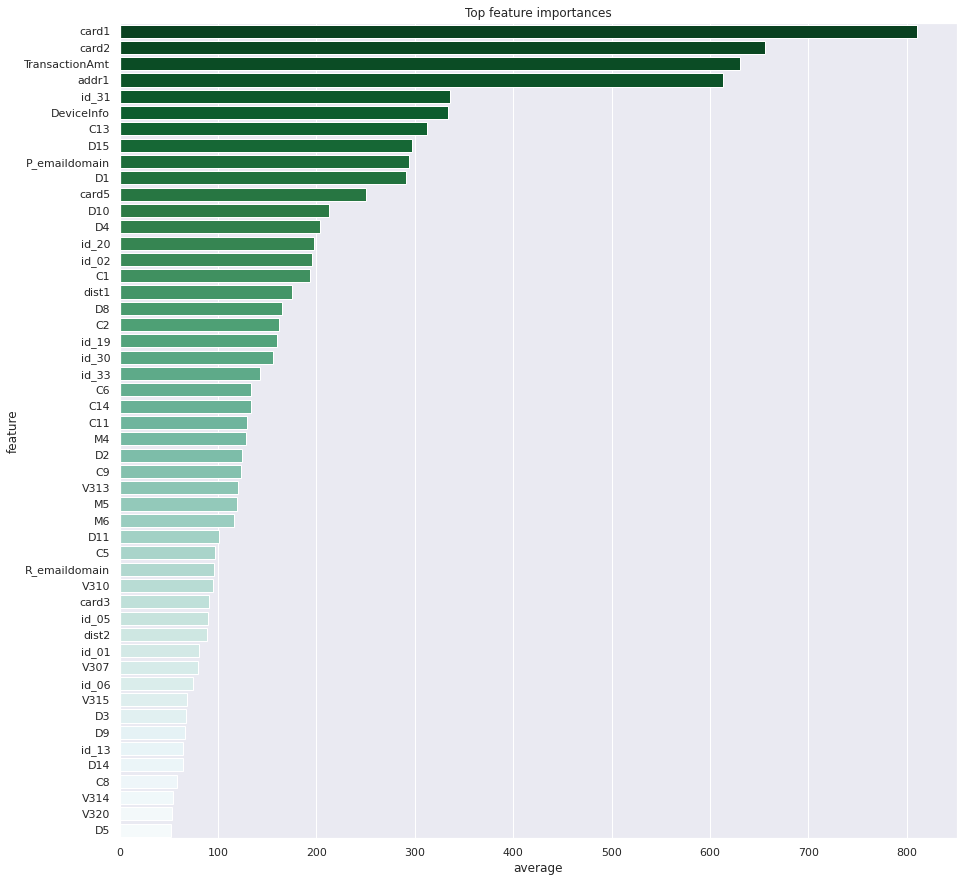

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

# Feature engineering

Для генерации признаков заново импортируем данные.

In [ ]:
INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [00:24<00:00, 17.71it/s]


Для того, чтобы улучшать качество предсказаний, можно не только менять модели и подбирать их гиперпараметры, но и модифицировать выборку. Это можно делать разными техниками - преобразования признаков, их отбор, извлечение новых и т.п. Это может помочь в силу того, что модель иногда не способна увидеть закономерности, скрытые внутри признаков, в отличие от человека, который может выделить их вручную. Подобные операции даже могут привести к появлению так называемых "magic features": их добавление к выборке может дать сильный прирост в качестве. Пример: [magic features от золотого призера одного из соревнований](https://www.kaggle.com/jturkewitz/magic-features-0-03-gain).

Посмотрим на распределение значений числового признака `'TransactionAmt'` в обучающей выборке:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


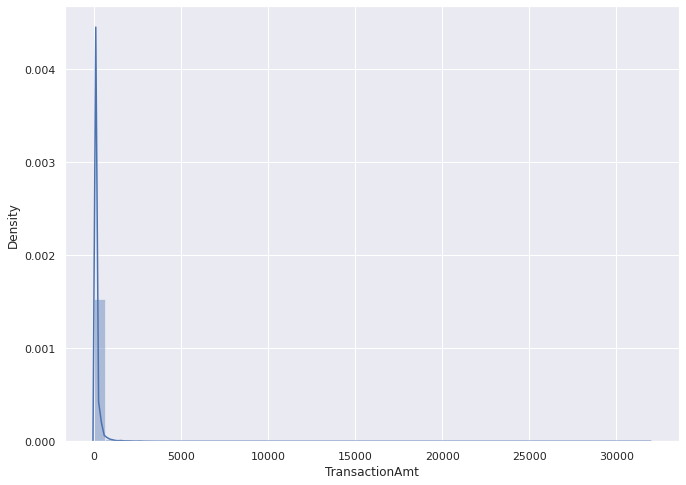

In [ ]:
plt.figure(figsize=(11, 8))
sns.distplot(df_train['TransactionAmt'])
plt.show()

Как видно, распределение очень сильно смещено. Прологарифмируем признак и добавим результат в данные как новый:

In [ ]:
df_train['TransactionAmt_log'] = np.log1p(df_train['TransactionAmt'])
df_test['TransactionAmt_log'] = np.log1p(df_test['TransactionAmt'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


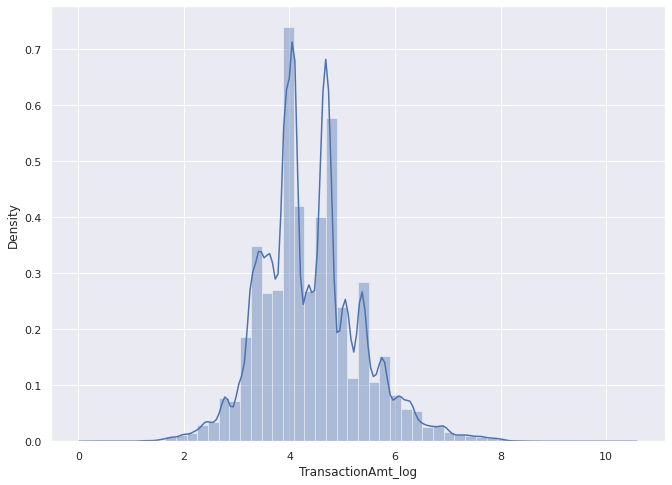

In [ ]:
plt.figure(figsize=(11, 8))
sns.distplot(df_train['TransactionAmt_log'])
plt.show()

Итак, распределение мы выровняли.

Заметим, что отнюдь не все суммы транзакций (в долларах) - целочисленные:

In [ ]:
df_train['TransactionAmt'].value_counts()[:15]

59.000000     20509
117.000000    19544
100.000000    16685
107.949997    15869
57.950001     15615
50.000000     14270
49.000000     10725
226.000000     7966
39.000000      7490
29.000000      7177
150.000000     6700
47.950001      6448
25.000000      6166
35.950001      5888
171.000000     5245
34.000000      5209
200.000000     5183
30.950001      5082
77.000000      4974
25.950001      4905
75.000000      4109
209.949997     4099
335.000000     3900
67.949997      3533
159.949997     3176
97.000000      3163
92.000000      2887
30.000000      2842
250.000000     2781
58.950001      2455
40.000000      2412
108.500000     2316
108.949997     2288
15.000000      2200
Name: TransactionAmt, dtype: int64

Это означает, что можно рассмотреть признак "количество центов" (вдруг мошенничество чаще совершается в случае "нецелых" транзакций?). Добавим его в данные и построим два его распределения: для мошеннических и обычных транзакций.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


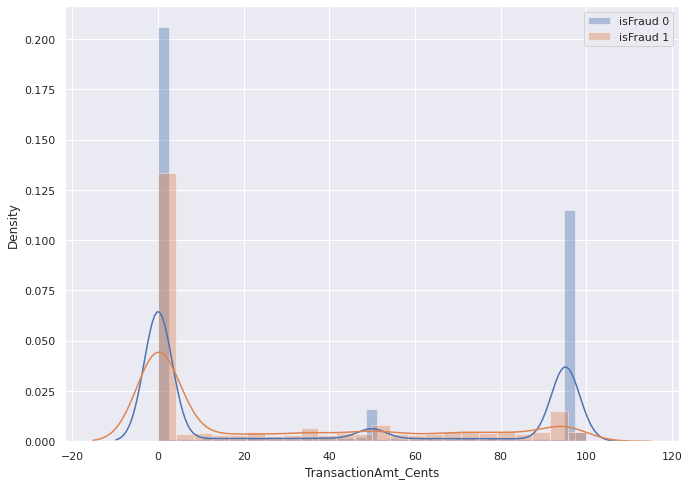

In [ ]:
df_train['TransactionAmt_Cents'] = np.modf(df_train['TransactionAmt'])[0] * 100
df_test['TransactionAmt_Cents'] = np.modf(df_test['TransactionAmt'])[0] * 100

plt.figure(figsize=(11, 8))
sns.distplot(df_train[df_train['isFraud'] == 0]['TransactionAmt_Cents'], label='isFraud 0')
sns.distplot(df_train[df_train['isFraud'] == 1]['TransactionAmt_Cents'], label='isFraud 1')
plt.legend(loc='best')
plt.show()

Из имеющихся признаков можно извлекать новые. Многие признаки анонимизированы, однако есть достаточно понятные - скажем, почта или OS устройства, с которого совершалась транзакция. Извлечем новый признак - окончание почты, который может нести в себе какую-нибудь информацию - например, информацию о стране (если название домена заканчивается на `.fr`).

In [ ]:
for col in ['P_emaildomain', 'R_emaildomain']:
    df_train[col + '_suffix'] = df_train[col].map(lambda x: str(x).split('.')[-1])
    df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])

df_train[['P_emaildomain', 'P_emaildomain_suffix', 'R_emaildomain', 'R_emaildomain_suffix']].tail(10)

,P_emaildomain,P_emaildomain_suffix,R_emaildomain,R_emaildomain_suffix
417549,gmail.com,com,NaN,nan
417550,gmail.com,com,NaN,nan
417551,att.net,net,NaN,nan
417552,anonymous.com,com,NaN,nan
417553,yahoo.com,com,NaN,nan
417554,gmail.com,com,NaN,nan
417555,gmail.com,com,NaN,nan
417556,hotmail.com,com,hotmail.com,com
417557,gmail.com,com,NaN,nan
417558,gmail.com,com,NaN,nan


Новые признаки можно извлекать на основании сочетаний некоторых имеющихся. Например, добавим в данные признак, отвечающий за то, совпадают ли домены покупателя и получателя - вдруг это что-то даст.

In [ ]:
df_train['same_emaildomain'] = (df_train['P_emaildomain'] == df_train['R_emaildomain']).astype('uint8')
df_test['same_emaildomain'] = (df_test['P_emaildomain'] == df_test['R_emaildomain']).astype('uint8')
df_train[['P_emaildomain', 'R_emaildomain', 'same_emaildomain']].tail()

,P_emaildomain,R_emaildomain,same_emaildomain
417554,gmail.com,NaN,0
417555,gmail.com,NaN,0
417556,hotmail.com,hotmail.com,1
417557,gmail.com,NaN,0
417558,gmail.com,NaN,0


Можно комбинировать признаки - производить арифметические операции между числовыми признаками, использовать сочетания категориальных. Такие комбинации иногда позволяют породить мощные признаки. Например, если какие-то из признаков `'card1'-'card6'` и `'addr1'-'addr2'` содержат важную информацию о клиенте, то объединение некоторых из них может помочь лучше идентифицировать клиента и факт мошенничества в транзакции. Главное не переусердствовать - если признаки содержат очень много категорий, то их объединение скорее всего приведет к появлению признака с колоссальным количеством категорий, что в свою очередь может привести к ухудшению качества. Из полученного признака тогда можно извлечь какую-то информацию с помощью группировки и агрегирования, но оставлять его просто так, скорее всего, опасно. Чтобы понять, о чем речь, попробуйте объединить признаки `'card1'` и `'card2'` - это два самых важных признака для модели из бейзлайна.

В данном случае скомбинируем признаки `'card3'` и `'card5'` - они входят в топ-50 важных признаков для модели из бейзлайна.

In [ ]:
df_train['card3_card5'] = df_train['card3'].astype(str) + '_' + df_train['card5'].astype(str)
df_test['card3_card5'] = df_test['card3'].astype(str) + '_' + df_test['card5'].astype(str)
df_train[['card3', 'card5', 'card3_card5']].head(10)

,card3,card5,card3_card5
0,150,142,150_142
1,150,102,150_102
2,150,166,150_166
3,150,117,150_117
4,150,102,150_102
5,150,226,150_226
6,150,166,150_166
7,150,226,150_226
8,150,226,150_226
9,150,224,150_224


In [ ]:
for col in ['card3', 'card5', 'card3_card5']:
    print('Number of categories in train for {}: {}'.format(col, df_train[col].nunique()))

Number of categories in train for card3: 106
Number of categories in train for card5: 111
Number of categories in train for card3_card5: 553


Можно также закодировать категориальные признаки, исходя из их частоты встречаемости в выборке.

In [ ]:
for col in ['card1', 'card2']:
    card_freq = df_train[col].value_counts().to_dict()
    df_train['{}_cnt'.format(col)] = df_train[col].map(card_freq)
    df_test['{}_cnt'.format(col)] = df_test[col].map(card_freq)
df_train[['card1', 'card1_cnt', 'card2', 'card2_cnt']].head(10)

,card1,card1_cnt,card2,card2_cnt
0,13926,29,99,6563
1,2755,526,404,2371
2,4663,778,490,26366
3,18132,2970,567,4329
4,4497,9,514,10587
5,5937,6,555,29919
6,12308,163,360,10518
7,12695,4837,490,26366
8,2803,4291,100,5372
9,17399,1293,111,31710


Наконец, можно использовать агрегирование и группировку. Например, наряду с `'card1'` и `'card2'`, одним из важнейших признаков для модели в бейзлайне является `'TransactionAmt'`. Давайте добавим в данные признаки, отвечающие за среднюю, медианную, максимальную и минимальную суммы покупок для каждой категории в `'card1'` и `'card2'`.

In [ ]:
%%time
new_cols = []
for col in ['card1', 'card2']:
    for agg_type in ['mean', 'median', 'min', 'max']:
        agg_col_name = 'TransactionAmt_{}_{}'.format(col, agg_type)
        card_agg = df_train.groupby(col)['TransactionAmt'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train = df_train.merge(card_agg, how='left', on=col)
        df_test = df_test.merge(card_agg, how='left', on=col)
        new_cols.append(agg_col_name)
df_train[['TransactionAmt', 'card1'] + new_cols[:4] + ['card2'] + new_cols[4:]].head(10)

CPU times: user 22.7 s, sys: 161 ms, total: 22.9 s
Wall time: 22.9 s


Напоследок отметим, что можно проводить также и отбор признаков - дело в том, что если в данных много неинформативных признаков, они могут лишь создать помехи при обучении. Способов отбора много, начиная от ручного и заканчивая специально разработанными для этого методами. В данном случае мы оставим все как есть.

После всех операций с признаками удалим столбец `'TransactionAmt'`, раз он уже есть у нас в логарифмированном виде - чтобы модель на него не отвлекалась.

In [ ]:
df_train.drop('TransactionAmt', axis=1, inplace=True)
df_test.drop('TransactionAmt', axis=1, inplace=True)

Подготовим полученную выборку к обучению модели так же, как мы делали это в обычном бейзлайне.

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
        
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

100%|██████████| 448/448 [00:16<00:00, 26.80it/s]


Обучим модель с теми же гиперпараметрами, что и в обычном бейзлайне.

In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 100,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.891287
[200]	valid_0's auc: 0.897135
[300]	valid_0's auc: 0.902009
[400]	valid_0's auc: 0.903017
[500]	valid_0's auc: 0.904667
[600]	valid_0's auc: 0.903922
Early stopping, best iteration is:
[514]	valid_0's auc: 0.904768


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.91555
[200]	valid_0's auc: 0.922687
[300]	valid_0's auc: 0.924285
[400]	valid_0's auc: 0.924867
[500]	valid_0's auc: 0.926251
[600]	valid_0's auc: 0.925895
Early stopping, best iteration is:
[519]	valid_0's auc: 0.926892


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.921538
[200]	valid_0's auc: 0.927039
[300]	valid_0's auc: 0.930288
[400]	valid_0's auc: 0.931506
Early stopping, best iteration is:
[370]	valid_0's auc: 0.931781


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.901318
[200]	valid_0's auc: 0.90597
[300]	valid_0's auc: 0.908344
[400]	valid_0's auc: 0.908186
Early stopping, best iteration is:
[359]	valid_0's auc: 0.909533
Fold 0, AUC-ROC: 0.90477
Fold 1, AUC-ROC: 0.92689
Fold 2, AUC-ROC: 0.93178
Fold 3, AUC-ROC: 0.90953
CV AUC-ROC: 0.91824
CPU times: user 36min 51s, sys: 2.2 s, total: 36min 54s
Wall time: 18min 51s


In [ ]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3
0,ProductCD,29,30,36,35
1,card1,536,548,363,376
2,card2,315,321,225,187
3,card3,12,11,5,11
4,card4,11,11,4,8


In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,average
0,ProductCD,29,30,36,35,32.50
1,card1,536,548,363,376,455.75
2,card2,315,321,225,187,262.00
3,card3,12,11,5,11,9.75
4,card4,11,11,4,8,8.50


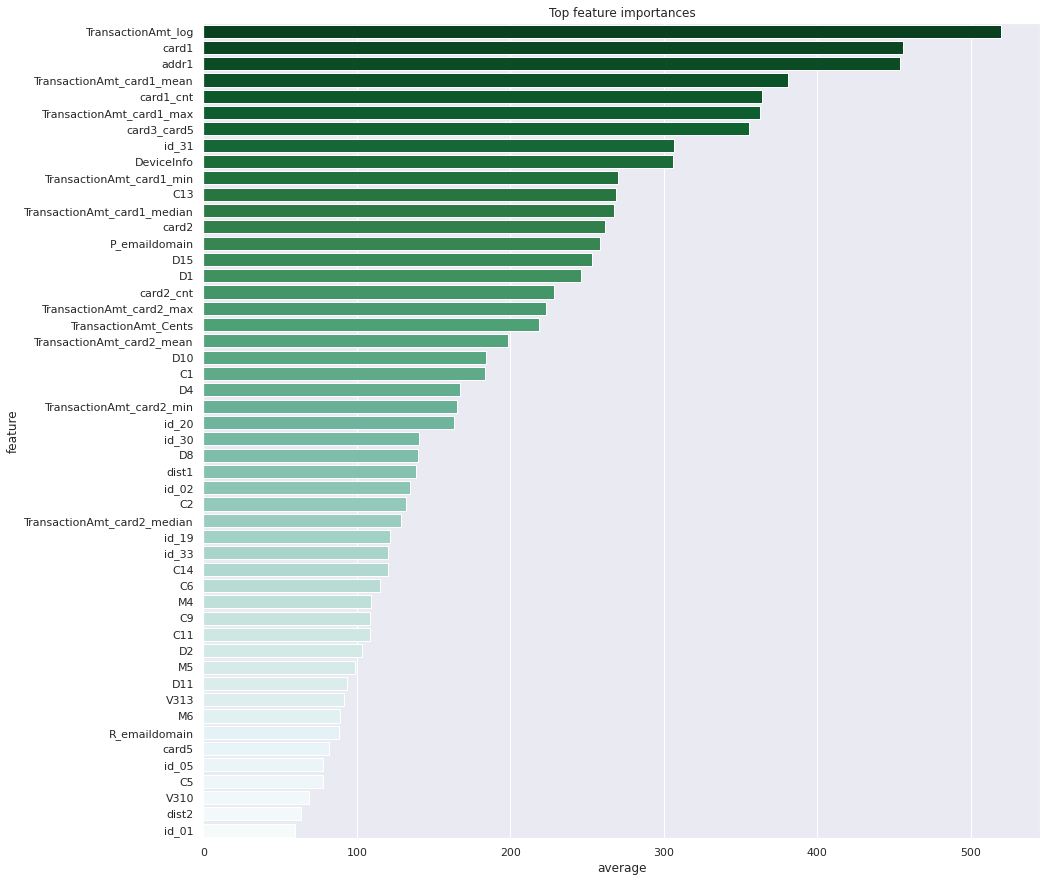

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Видно, что качество модели улучшилось, и в топе появились сгенерированные признаки - агрегации и счетчики. А также центы :)

Для получения итогового предсказания на тестовой выборке усредним предсказания моделей с разных фолдов.

In [ ]:
np.array(test_preds).shape

(4, 172981)

In [ ]:
final_pred = np.average(test_preds, axis=0)
final_pred

array([0.24581925, 0.10638248, 0.31093237, ..., 0.03102773, 0.11243461,
       0.03774598])

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.head()

,TransactionID,isFraud
0,3404559,0.245819
1,3404560,0.106382
2,3404561,0.310932
3,3404562,0.076318
4,3404563,0.618977


In [ ]:
sub.tail()

,TransactionID,isFraud
172976,3577535,0.042976
172977,3577536,0.060194
172978,3577537,0.031028
172979,3577538,0.112435
172980,3577539,0.037746


Сохраняем файл с предсказаниями - теперь его можно отправить в соревнование и посмотреть результат на публичной части.

In [ ]:
sub.to_csv('submission_baseline.csv', index=False)

Наконец, построим распределение предсказаний для целевой переменной на тестовой выборке.

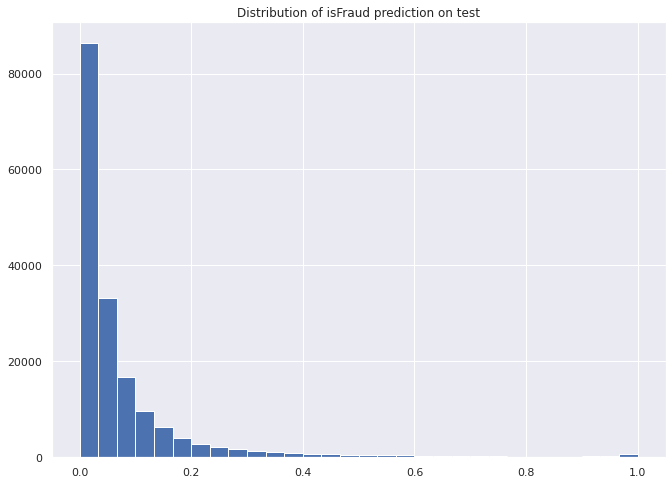

In [ ]:
plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

Теперь после отправки двух результатов в соревнование (бейзлайна и feature engineering) можно будет посмотреть, увеличилось или уменьшилось качество на публичной части тестовой выборки. Если качество уменьшилось по сравнению с обычным бейзлайном, это может означать, что построенная валидация не так хорошо коррелирует с лидербордом, как хотелось бы - ведь качество на валидации у нас выросло, значит и на лидерборде по-хорошему мы могли бы подняться. Таким образом, можно либо попробовать построить более хорошую валидационную стратегию, либо смириться и считать, что на приватной части все будет нормально (можно просто в качестве финального сабмита выбрать лучший с точки зрения валидации, либо наоборот - лучший по лидерборду) - этот шаг достаточно важен, так что его надо продумать.